In [6]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt

import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
from SplineEncodingModel.LinearRegressionSpline import EncodingModel, NBDecodingModel
from SplineEncodingModel import PopDecodingCV as pdcv
import matplotlib.gridspec as gridspec
import pickle

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]






G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [123]:
mouse = '4139265.4'
df_mouse = df[df['MouseName'].str.match(mouse)]
# df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]
df_mouse



,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1371,4139265.4,07_02_2019,2,TwoTower_foraging,60,1,CA1,2019-02-07,G:\My Drive\VR_Data\TwoTower\4139265.4\07_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...
1373,4139265.4,07_02_2019,4,TwoTower_foraging,60,1,CA1,2019-02-07,G:\My Drive\VR_Data\TwoTower\4139265.4\07_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...
1407,4139265.4,10_02_2019,2,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.4\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\10_02_2...
1436,4139265.4,12_02_2019,2,TwoTower_foraging,85,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.4\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\12_02_2...
1459,4139265.4,15_02_2019,3,TwoTower_foraging,82,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.4\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\15_02_2...
1478,4139265.4,17_02_2019,2,TwoTower_foraging,94,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.4\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\17_02_2...
1489,4139265.4,18_02_2019,2,TwoTower_foraging,101,1,CA1,2019-02-18,G:\My Drive\VR_Data\TwoTower\4139265.4\18_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\18_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\18_02_2...
1498,4139265.4,19_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.4\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\19_02_2...
1510,4139265.4,20_02_2019,2,TwoTower_foraging,99,1,CA1,2019-02-20,G:\My Drive\VR_Data\TwoTower\4139265.4\20_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\20_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\20_02_2...
1516,4139265.4,21_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.4\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\21_02_2...


In [124]:
sess = df_mouse.iloc[-1]

VRDat,C, S, A = pp.load_scan_sess(sess)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
C/=1546



num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601
frame diff 0


In [125]:
effMorph = (trial_info['morphs']+trial_info['wallJitter']+trial_info['towerJitter']+trial_info['bckgndJitter']+.25)/1.5
msort=np.argsort(effMorph)

In [126]:
fname = os.path.join('G:\My Drive\Figures\TwoTower\PosCtxtSplineGLM\\',"%s_%s_%s" % (mouse,sess['DateFolder'],sess['SessionNumber']),'mdloutput.pkl')

with open(fname,'rb') as f:
    results = pickle.load(f)

In [127]:
print(results.keys())

dict_keys(['Likelihood_XC', 'C_hat', 'cellmask'])


In [128]:
L_XC = results['Likelihood_XC']
print(L_XC.shape)

(32084, 50, 50)


In [129]:
ll_c = np.zeros([trial_info['morphs'].shape[0],50])
for t, (start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    ll_c[t,:] = np.log(L_XC[start:stop,:,:].sum(axis=1)).mean(axis=0)

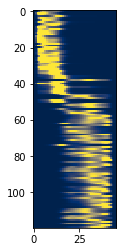

In [130]:
f,ax= plt.subplots()
ax.imshow(np.exp(ll_c[msort,2:-2]),cmap='cividis',vmax=.05)

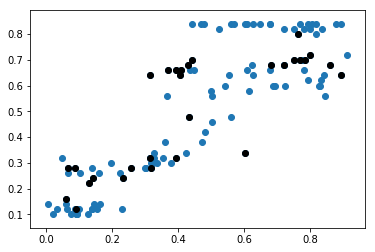

In [131]:
mlc = np.argmax(ll_c,axis=1)/50.
f,ax= plt.subplots()
ax.scatter(effMorph,mlc)
mlc_r = np.copy(mlc)
mlc_r[trial_info['rewards']>0]=np.nan
ax.scatter(effMorph,mlc_r,color='black')